In [2]:
# Colab-friendly setup (one cell)
# 1) install helpers
!pip install -q gdown duckdb

# 2) download Drive files by id (uses your links' file ids)
import gdown
gdown.download(id="1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs", output="historical_trades.csv", quiet=False)
gdown.download(id="1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf", output="fear_greed.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 90.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 3.41MB/s]


'fear_greed.csv'

In [3]:
import pandas as pd
import numpy as np

# ===== 1. Load Data =====
trades = pd.read_csv("historical_trades.csv")
fear_greed = pd.read_csv("fear_greed.csv")

# ===== 2. Convert Timestamps =====
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')
fear_greed['datetime'] = pd.to_datetime(fear_greed['timestamp'], unit='s', errors='coerce')
fear_greed['date'] = pd.to_datetime(fear_greed['date'], format="%Y-%m-%d", errors='coerce')

# ===== 3. Align Date Formats =====
trades['date'] = trades['Timestamp IST'].dt.date
fear_greed['date'] = fear_greed['date'].dt.date

# ===== 4. Sort for Rolling Calculations =====
fear_greed = fear_greed.sort_values(by='date')

# ===== 5. Extra Fear & Greed Features =====
fear_greed['FG_3d_avg'] = fear_greed['value'].rolling(window=3, min_periods=1).mean()
fear_greed['FG_1d_change'] = fear_greed['value'].pct_change(periods=1) * 100
fear_greed['FG_3d_change'] = fear_greed['value'].pct_change(periods=3) * 100
fear_greed['FG_7d_change'] = fear_greed['value'].pct_change(periods=7) * 100
fear_greed['FG_volatility_7d'] = fear_greed['value'].rolling(window=7, min_periods=1).std()
fear_greed['FG_spike_flag'] = (fear_greed['value'].diff().abs() > 15).astype(int)

# ===== 6. Merge Fear & Greed Index into Trades =====
merged = pd.merge(
    trades,
    fear_greed[['date', 'value', 'classification', 'FG_3d_avg',
                'FG_1d_change', 'FG_3d_change', 'FG_7d_change',
                'FG_volatility_7d', 'FG_spike_flag']],
    on='date', how='left'
)

# ===== 7. Fill missing Fear & Greed values =====
merged = merged.sort_values(by='Timestamp IST')
fg_cols = ['value', 'classification', 'FG_3d_avg', 'FG_1d_change',
           'FG_3d_change', 'FG_7d_change', 'FG_volatility_7d', 'FG_spike_flag']
merged[fg_cols] = merged[fg_cols].fillna(method='ffill').fillna(method='bfill')

# ===== 8. Feature Engineering =====
# Side encoding
merged['Side_encoded'] = merged['Side'].map({'BUY': 1, 'SELL': -1})

# Normalized sentiment score
merged['fear_greed_norm'] = (merged['value'] - merged['value'].min()) / (merged['value'].max() - merged['value'].min())

# Classification bucket mapping
classification_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
merged['FG_class_bucket'] = merged['classification'].map(classification_map)

# Profit per invested dollar
merged['PnL_ratio'] = merged['Closed PnL'] / merged['Size USD'].replace(0, np.nan)

# Contrarian trades flag (buy when FG low, sell when FG high)
merged['is_contrarian'] = (
    merged['Side_encoded'] * (merged['fear_greed_norm'] - 0.5) < 0
).astype(int)

# Temporal features
merged['hour'] = merged['Timestamp IST'].dt.hour
merged['day_of_week'] = merged['Timestamp IST'].dt.dayofweek
merged['is_weekend'] = merged['day_of_week'].isin([5, 6]).astype(int)

# ===== 9. Save Clean Dataset =====
merged.to_csv("merged_fear_greed_trades.csv", index=False)

print("✅ Enhanced dataset saved: merged_fear_greed_trades.csv")
print("Shape:", merged.shape)
print(merged.head())


/tmp/ipython-input-1715489323.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[fg_cols] = merged[fg_cols].fillna(method='ffill').fillna(method='bfill')


✅ Enhanced dataset saved: merged_fear_greed_trades.csv
Shape: (211224, 33)
                                          Account Coin  Execution Price  \
83770  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1897.9   
83771  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1898.6   
83769  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  ETH           1897.9   
39063  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  BTC          41866.0   
39062  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  BTC          41867.0   

       Size Tokens  Size USD  Side       Timestamp IST  Start Position  \
83770      0.08240    156.39   BUY 2023-05-01 01:06:00          0.0967   
83771      0.07220    137.08   BUY 2023-05-01 01:06:00          0.1791   
83769      0.09670    183.53   BUY 2023-05-01 01:06:00          0.0000   
39063      0.58211  24370.62  SELL 2023-12-05 03:11:00         -0.0150   
39062      0.01500    628.00  SELL 2023-12-05 03:11:00          0.0000   

        Direction  Closed PnL

/tmp/ipython-input-2268833465.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='classification',
/tmp/ipython-input-2268833465.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_rate.index, y=win_rate.values, palette='viridis', ax=axes[0, 2])
/tmp/ipython-input-2268833465.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Fear', 'Greed'], y=[avg_pnl_fear, avg_pnl_greed],


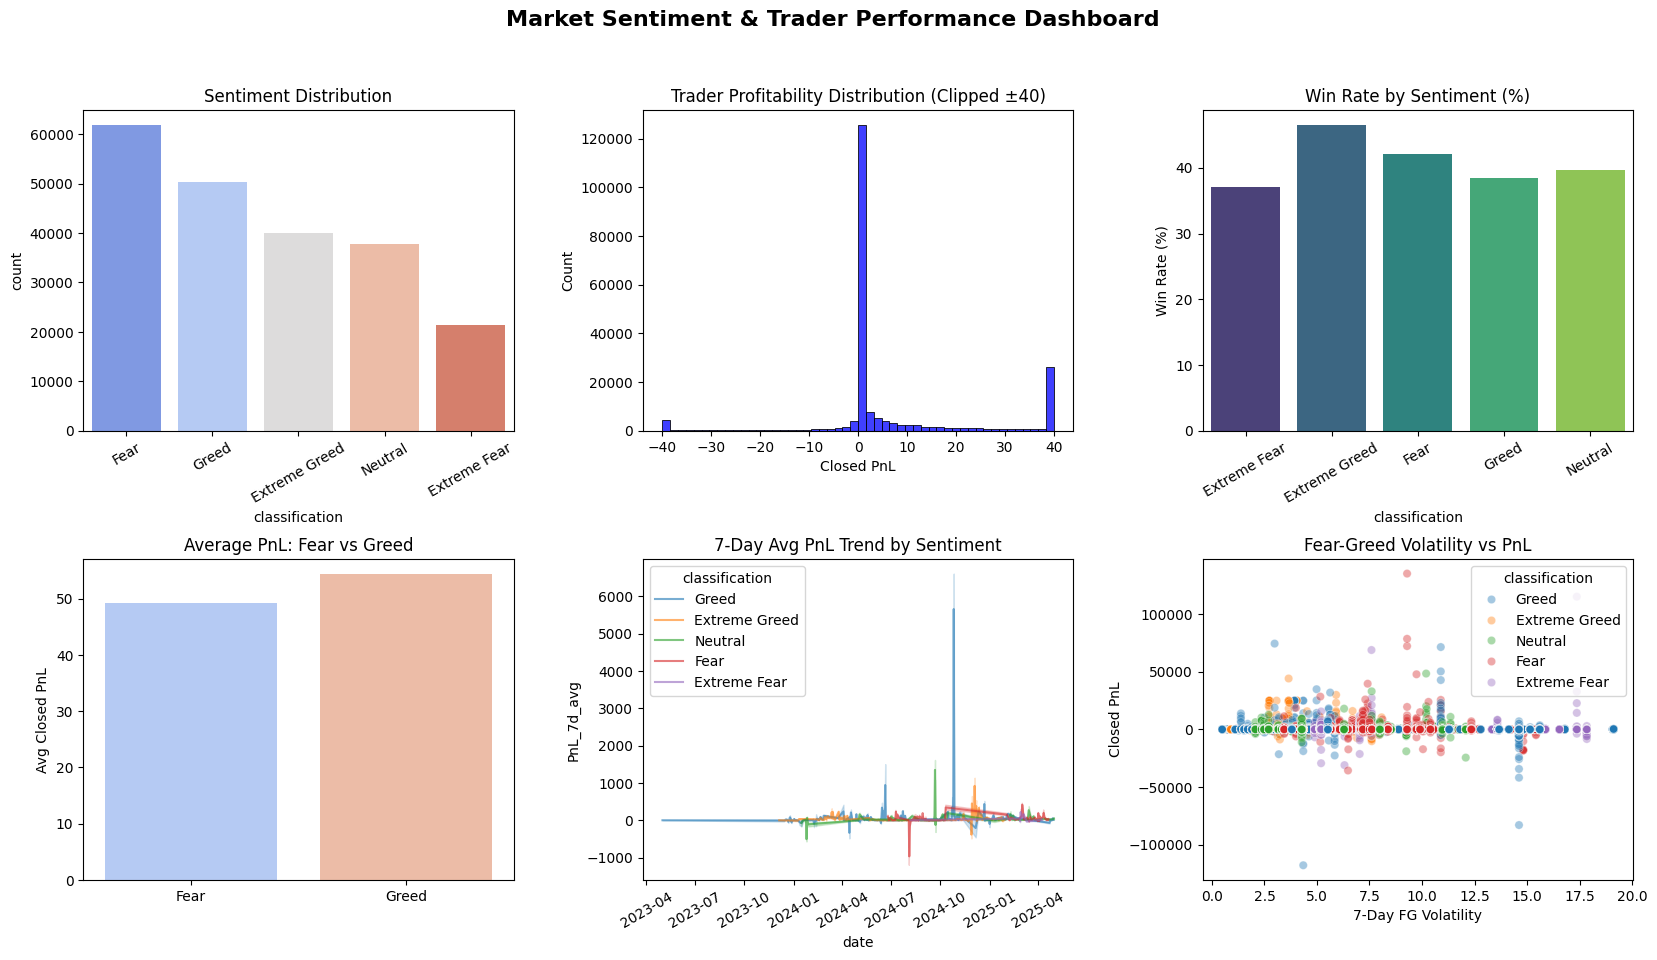

✅ Dashboard generated & dataset with engineered features saved.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------
# 1. Load Data
# -----------------
df = pd.read_csv("merged_fear_greed_trades.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['Timestamp IST'] = pd.to_datetime(df['Timestamp IST'], errors='coerce')

numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee',
                'value', 'FG_3d_avg', 'FG_1d_change', 'FG_3d_change', 'FG_7d_change',
                'FG_volatility_7d', 'fear_greed_norm']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# -----------------
# 2. Feature Engineering for Trends
# -----------------
df['is_win'] = (df['Closed PnL'] > 0).astype(int)
df['PnL_7d_avg'] = df.groupby('Coin')['Closed PnL'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

df['Size_Tokens_3d_avg'] = df.groupby('Account')['Size Tokens'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['Price_volatility_7d'] = df.groupby('Coin')['Execution Price'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df['Size_Tokens_norm'] = df.groupby('Coin')['Size Tokens'].transform(lambda x: (x - x.mean()) / x.std())
df['Closed_PnL_norm'] = (df['Closed PnL'] - df['Closed PnL'].mean()) / df['Closed PnL'].std()

# -----------------
# 3. Prepare Data for Plots
# -----------------
win_rate = df.groupby('classification')['is_win'].mean() * 100
fear_mask = df['classification'].isin(['Fear', 'Extreme Fear'])
greed_mask = df['classification'].isin(['Greed', 'Extreme Greed'])
avg_pnl_fear = df[fear_mask]['Closed PnL'].mean()
avg_pnl_greed = df[greed_mask]['Closed PnL'].mean()
pnl_clipped = df['Closed PnL'].clip(lower=-40, upper=40)

# -----------------
# 4. Create Dashboard Layout
# -----------------
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Sentiment Distribution
sns.countplot(data=df, x='classification',
              order=df['classification'].value_counts().index,
              palette='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title("Sentiment Distribution")
axes[0, 0].tick_params(axis='x', rotation=30)

# Trader Profitability Distribution (Clipped ±40)
sns.histplot(pnl_clipped, bins=50, color='blue', ax=axes[0, 1])
axes[0, 1].set_title("Trader Profitability Distribution (Clipped ±40)")

# Win Rate by Sentiment
sns.barplot(x=win_rate.index, y=win_rate.values, palette='viridis', ax=axes[0, 2])
axes[0, 2].set_title("Win Rate by Sentiment (%)")
axes[0, 2].set_ylabel("Win Rate (%)")
axes[0, 2].tick_params(axis='x', rotation=30)

# Average PnL: Fear vs Greed
sns.barplot(x=['Fear', 'Greed'], y=[avg_pnl_fear, avg_pnl_greed],
            palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title("Average PnL: Fear vs Greed")
axes[1, 0].set_ylabel("Avg Closed PnL")

# 7-Day Avg PnL Trend by Sentiment
sns.lineplot(data=df, x='date', y='PnL_7d_avg', hue='classification',
             alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title("7-Day Avg PnL Trend by Sentiment")
axes[1, 1].tick_params(axis='x', rotation=30)

# Volatility vs PnL relationship
sns.scatterplot(data=df, x='FG_volatility_7d', y='Closed PnL',
                hue='classification', alpha=0.4, ax=axes[1, 2])
axes[1, 2].set_title("Fear-Greed Volatility vs PnL")
axes[1, 2].set_xlabel("7-Day FG Volatility")
axes[1, 2].set_ylabel("Closed PnL")

plt.suptitle("Market Sentiment & Trader Performance Dashboard", fontsize=16, fontweight='bold')
plt.show()

# -----------------
# 5. Save updated dataset
# -----------------
df.to_csv("merged_fear_greed_trades_features.csv", index=False)
print("✅ Dashboard generated & dataset with engineered features saved.")


Risk-adjusted metrics by sentiment:
   classification   mean_pnl      std_pnl  median_pnl   skew_pnl  kurtosis_pnl  \
0   Extreme Fear  34.537862  1136.056091         0.0  60.061788   5705.555683   
1  Extreme Greed  67.892861   766.828294         0.0  26.168860    923.912560   
2           Fear  54.290400   935.355438         0.0  71.337201   8755.902442   
3          Greed  43.582684  1120.064348         0.0 -15.540365   4070.529688   
4        Neutral  34.307718   517.122220         0.0  32.301200   2908.841779   

   win_rate    sharpe  sortino  
0  0.370607  0.030402      NaN  
1  0.464943  0.088537      NaN  
2  0.420768  0.058043      NaN  
3  0.384901  0.038911      NaN  
4  0.396991  0.066344      NaN  


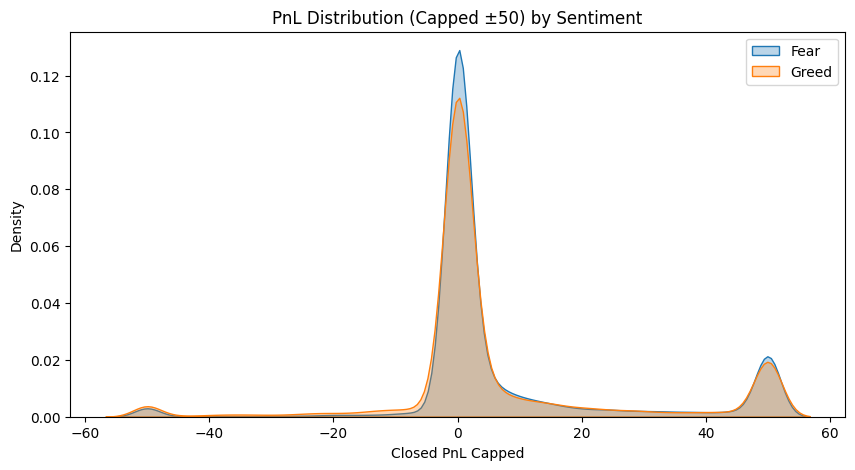

Top trader PnL quantiles:
                      0.90        0.95         0.99
classification                                    
Extreme Fear    61.438889  179.650728   911.102219
Extreme Greed   75.052456  204.483944  1198.631756
Fear            52.958788  156.722996  1174.440013
Greed           54.657075  166.505735   931.730407
Neutral         40.184518  124.258071   850.922162


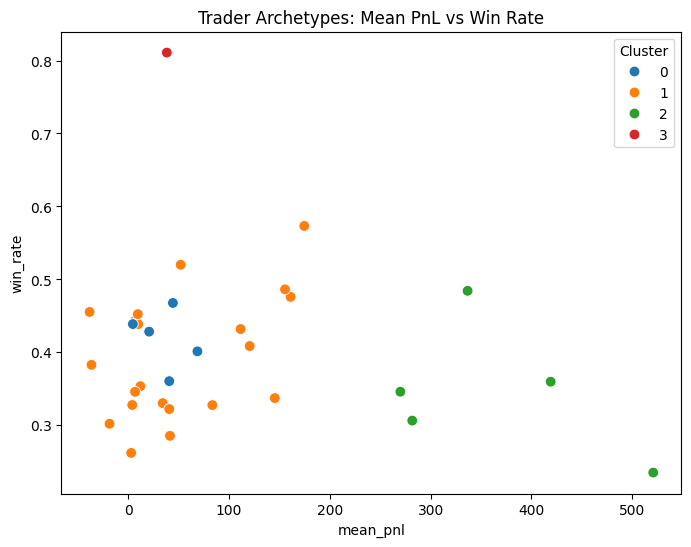

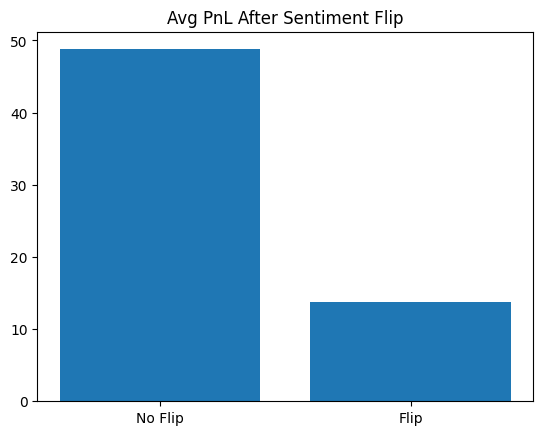

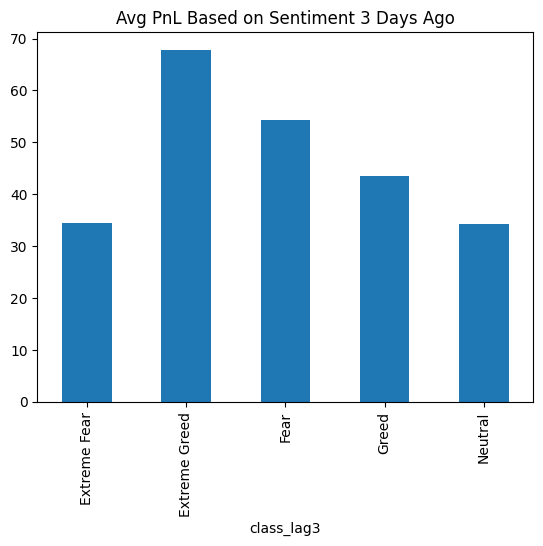

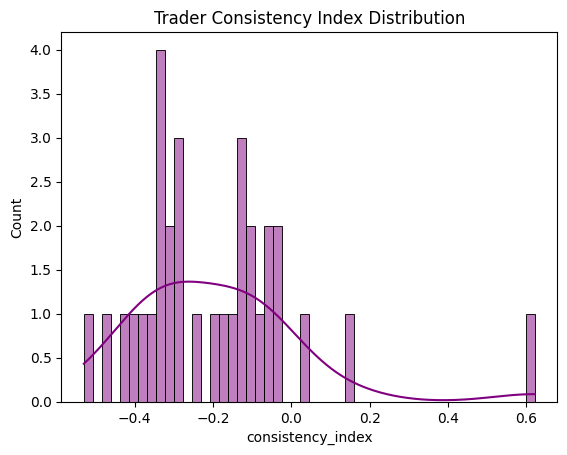

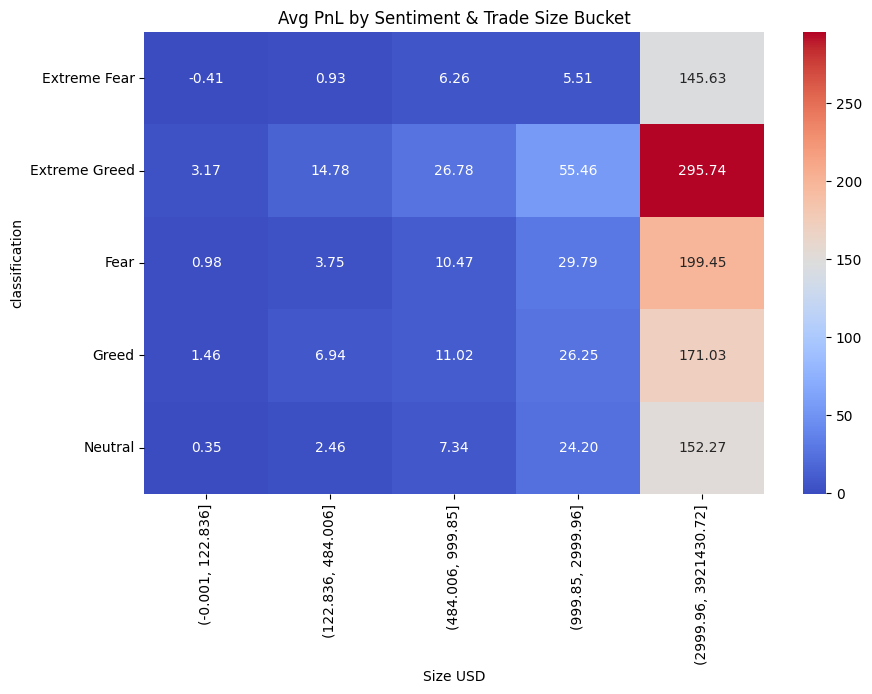

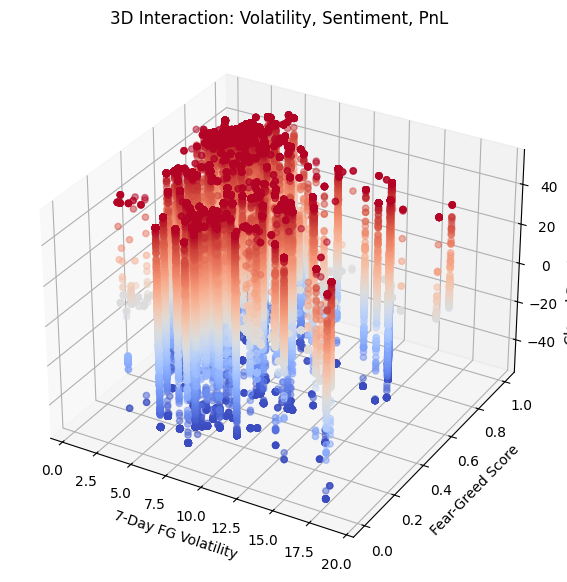

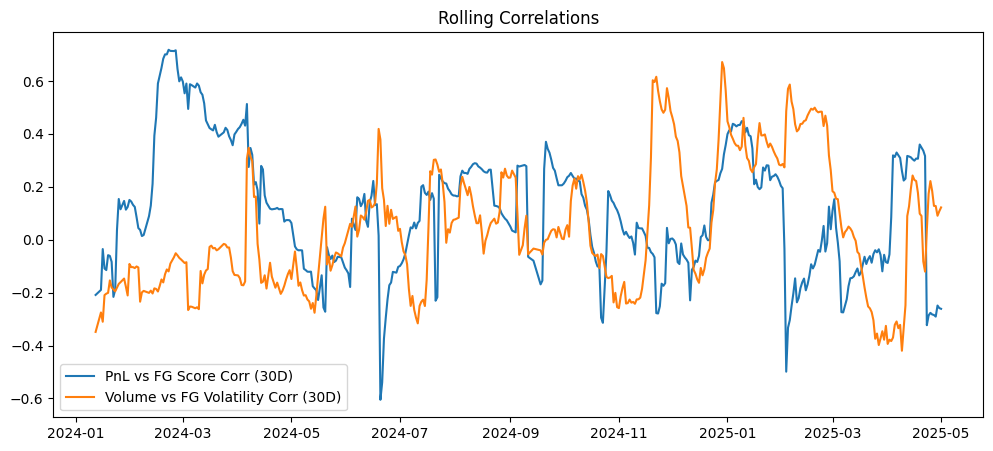

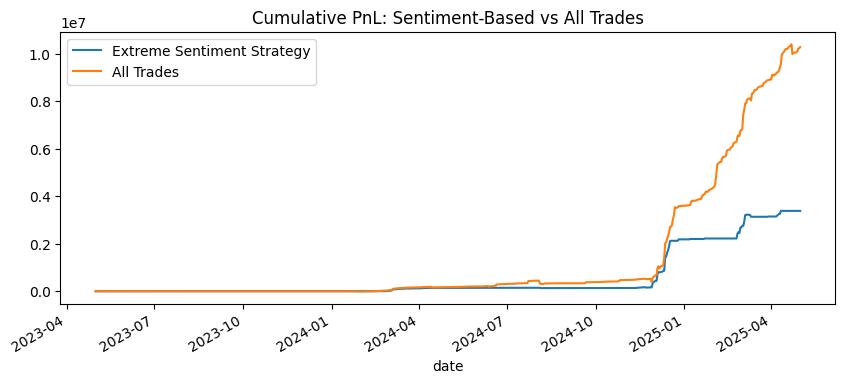

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# --------------------
# 1. Load Dataset
# --------------------
df = pd.read_csv("merged_fear_greed_trades.csv", parse_dates=["date", "Timestamp IST"])
df['is_win'] = (df['Closed PnL'] > 0).astype(int)

# Cap PnL for plots
df['Closed PnL Capped'] = df['Closed PnL'].clip(lower=-50, upper=50)

# --------------------
# 1. Sentiment-Conditioned Performance Profiles
# --------------------
perf = df.groupby('classification').agg(
    mean_pnl=('Closed PnL','mean'),
    std_pnl=('Closed PnL','std'),
    median_pnl=('Closed PnL','median'),
    skew_pnl=('Closed PnL', skew),
    kurtosis_pnl=('Closed PnL', kurtosis),
    win_rate=('is_win','mean')
).reset_index()

perf['sharpe'] = perf['mean_pnl'] / perf['std_pnl']
perf['sortino'] = perf['mean_pnl'] / df.groupby('classification')['Closed PnL'].apply(
    lambda x: np.sqrt((x[x<0]**2).mean()) if any(x<0) else np.nan
)
print("Risk-adjusted metrics by sentiment:\n", perf)

# Kernel Density of capped PnL
plt.figure(figsize=(10,5))
for c in ['Fear','Greed']:
    sns.kdeplot(df[df['classification']==c]['Closed PnL Capped'], label=c, fill=True, alpha=0.3)
plt.title("PnL Distribution (Capped ±50) by Sentiment")
plt.legend()
plt.show()

# Quantile Analysis
quantiles = df.groupby('classification')['Closed PnL'].quantile([0.9,0.95,0.99]).unstack()
print("Top trader PnL quantiles:\n", quantiles)

# --------------------
# 2. Trader Archetypes & Clustering
# --------------------
trader_stats = df.groupby('Account').agg(
    mean_pnl=('Closed PnL','mean'),
    pnl_std=('Closed PnL','std'),
    avg_size_usd=('Size USD','mean'),
    avg_size_tokens=('Size Tokens','mean'),
    win_rate=('is_win','mean'),
    trade_count=('Closed PnL','size')
).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_stats)

kmeans = KMeans(n_clusters=4, random_state=42)
trader_stats['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=trader_stats, x='mean_pnl', y='win_rate', hue='Cluster', palette='tab10', s=60)
plt.title("Trader Archetypes: Mean PnL vs Win Rate")
plt.show()

# --------------------
# 3. Sentiment Shift Impact
# --------------------
df = df.sort_values('date')
df['prev_class'] = df['classification'].shift(1)
df['sentiment_flip'] = (df['classification'] != df['prev_class']).astype(int)

flip_impact = df.groupby('sentiment_flip')['Closed PnL'].mean()
plt.bar(['No Flip','Flip'], flip_impact)
plt.title("Avg PnL After Sentiment Flip")
plt.show()

# Lag effects (3-day lag)
df['class_lag3'] = df['classification'].shift(3)
lagged = df.groupby('class_lag3')['Closed PnL'].mean().dropna()
lagged.plot(kind='bar', title="Avg PnL Based on Sentiment 3 Days Ago")
plt.show()

# --------------------
# 4. Trader Consistency Scores
# --------------------
consistency = df.groupby('Account').agg(
    wins=('is_win','sum'),
    losses=('is_win', lambda x: (1-x).sum()),
    total=('is_win','count')
)
consistency['consistency_index'] = (consistency['wins'] - consistency['losses']) / consistency['total']
sns.histplot(consistency['consistency_index'], bins=50, kde=True, color='purple')
plt.title("Trader Consistency Index Distribution")
plt.show()

# --------------------
# 5. Avg PnL by Sentiment & Trade Size
# --------------------
size_bins = pd.qcut(df['Size USD'], q=5, duplicates='drop')
heatmap_data = df.pivot_table(
    index='classification',
    columns=size_bins,
    values='Closed PnL',
    aggfunc='mean'
)
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Avg PnL by Sentiment & Trade Size Bucket")
plt.show()

# --------------------
# 6. Volatility–Sentiment–PnL Interaction
# --------------------
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['FG_volatility_7d'], df['fear_greed_norm'], df['Closed PnL Capped'],
           c=df['Closed PnL Capped'], cmap='coolwarm', alpha=0.5)
ax.set_xlabel("7-Day FG Volatility")
ax.set_ylabel("Fear-Greed Score")
ax.set_zlabel("Closed PnL (Capped ±50)")
plt.title("3D Interaction: Volatility, Sentiment, PnL")
plt.show()

# --------------------
# 7. Rolling Correlation Analysis
# --------------------
daily = df.groupby('date').agg(
    total_pnl=('Closed PnL','sum'),
    mean_fg=('fear_greed_norm','mean'),
    fg_volatility=('FG_volatility_7d','mean'),
    trade_volume=('Size USD','sum')
).sort_index()

roll_corr_fg = daily['total_pnl'].rolling(30).corr(daily['mean_fg'])
roll_corr_vol = daily['trade_volume'].rolling(30).corr(daily['fg_volatility'])

plt.figure(figsize=(12,5))
plt.plot(roll_corr_fg, label='PnL vs FG Score Corr (30D)')
plt.plot(roll_corr_vol, label='Volume vs FG Volatility Corr (30D)')
plt.legend()
plt.title("Rolling Correlations")
plt.show()

# --------------------
# 8. 'What If' Backtest
# --------------------
extreme_mask = (daily['mean_fg'] <= 0.2) | (daily['mean_fg'] >= 0.8)
daily['signal'] = extreme_mask.astype(int)
daily['strategy_pnl'] = daily['signal'] * daily['total_pnl']

plt.figure(figsize=(10,4))
daily['strategy_pnl'].cumsum().plot(label='Extreme Sentiment Strategy')
daily['total_pnl'].cumsum().plot(label='All Trades')
plt.legend()
plt.title("Cumulative PnL: Sentiment-Based vs All Trades")
plt.show()
